In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob

from astropy.io import fits
from astropy.time import Time

Let's work with one of the IMACS HATS-5b datasets. I've stored the December 27, 2015 dataset in my computer here:

In [2]:
datadir = '/Volumes/espinoza_backup/ACCESS/HATS-5b/hats5_ut151227'

# 1. Getting acquinted with the dataset

First thing to note in these datasets is that there are several files that end on "c1", "c2", "c3", etc. Each of those are _chips_; or simply put, different CCD cameras. With Ben Rackham we wrote some scripts (`get_mask_coords.py` and `test_mask_coords.py`) to extract the position of the different observed targets in those chips in order to plot them. 

The product of the `get_mask_coords.py` script are the (approximate) coordinates of the objects observed in a given night. This uses a so-called `SMF` file (`hats5sn.SMF` in this case), which is the file used to actually make holes in our masks. In particular, for this dataset this code has already been ran and this produced the `20151227_HATS5_coords` file, which we can use to plot the chips and the corresponding targets. These "coords" files are important because they serve as inputs for pipelines (in particular, to our IMACS pipeline). 

We can plot this as follows, using some routines I've copied here on the `utils.py` file:

In [3]:
import utils

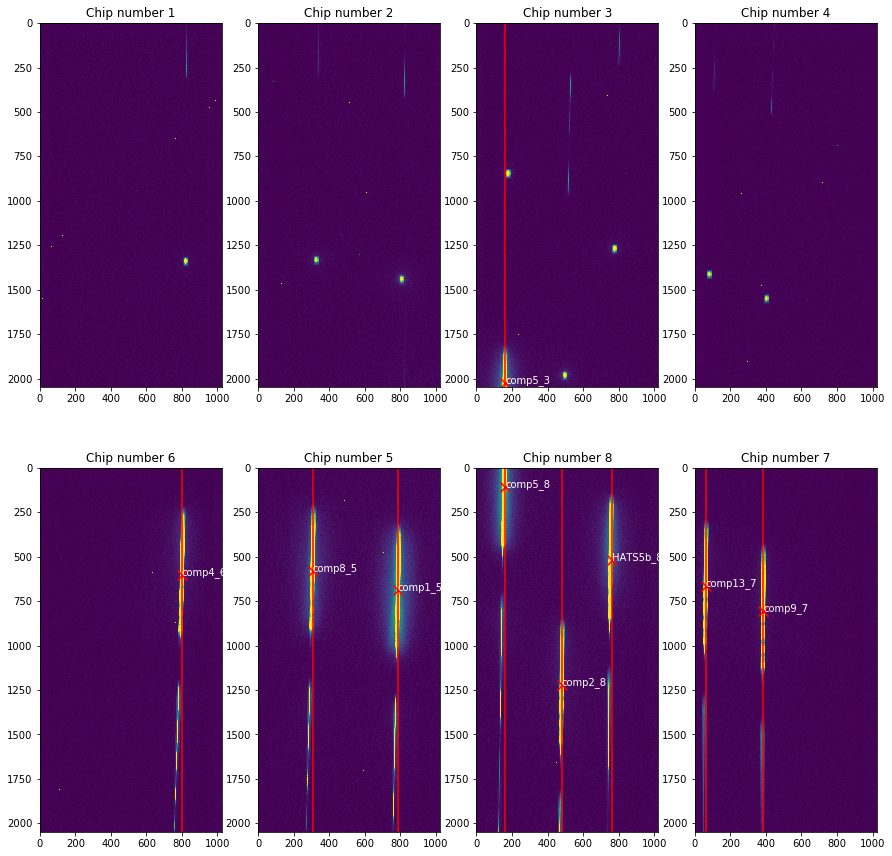

In [4]:
coords = utils.InputCoords(datadir+'/20151227_HATS5_coords')
file = 'ift0320'
otype = file[0:3]
chips = ['c1','c2','c3','c4','c6','c5','c8','c7']
order = [1, 2, 3, 4, 6, 5, 8, 7]
ranges = [0,600]

plt.figure(figsize=(15,15))
for i in range(8):
    plt.subplot(int('24'+str(i+1)))
    d,h = fits.getdata(datadir+'/'+file+chips[i]+'.fits',header=True)
    d = utils.BiasTrim(d,chips[i],h,otype)
    binning = int(h['binning'][0])
    im = plt.imshow(d)#.transpose())
    for c in range(len(coords.chip)):
        if order[i]==coords.chip[c]:
            plt.scatter(coords.x[c], coords.y[c], s=100, marker='x', color='r')
            plt.plot([coords.x[c], coords.x[c]], [0, 4096/binning], 'r')
            plt.text(coords.x[c], coords.y[c], coords.obj[c], color='white')
    plt.title('Chip number '+(chips[i])[1:])
    if (chips[i])[1:] in ['1', '2', '3', '4']:
        plt.ylim(2048,0)
    else:
        plt.ylim(2048,0)
    im.set_clim(ranges[0],ranges[1])

Cool! Lots to take from this plot --- but the main deal for our quicklook, is that the chip on which our target star (HATS-5) is located is chip 8. For our simple quicklook below, let's work with data form that chip only. Let's use the star `comp2_8` as _the_ comparison star.

In [5]:
# Load all mods2b frames filenames:
files = glob.glob(datadir+'/ift*c8.fits')
# Sort them:
files.sort()

Most datasets have a night-log, and even some with measurements on, e.g., gains. For this particular dataset, that file is `hats5.151227.txt`. In it, we can see that the science frames were taken from frame 101 until 475. We keep that in mind below (science frames are also evident from the headers, so we _could_ have figured this out from them).

# 2. Initial data checks

All right, let's check frame 101 for chip 8 (i.e., the first science frame), just to see the data structure:

In [6]:
d = fits.open(datadir+'/ift0101c8.fits')
data, headers = d['PRIMARY'].data, d['PRIMARY'].header

First, let's plot the image:

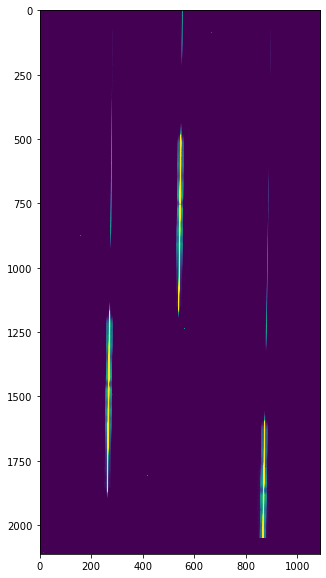

In [7]:
plt.figure(figsize=(10,10))
im = plt.imshow(data)
im.set_clim(1000,5000)

Note this is "upside down" and "reflected" from the multiple-chip plot above. So HATS-5, our target star, is the left-most spectra; with the comparison star to the right of it (in the middle).

Let's make some cuts around those two objects, in order to perform a "quick-reduction" of this data. By eye, it seems the left spectra (the target) goes from about 230 to 330; whereas the spectra to its right goes from 500 to 600 (all this was done via trial and error with the script below by the way). Let's see if that's correct (we transpose them as in my mind is better to have wavelength on the "x-direction", and flux on the "y-direction":

Text(0.5, 1.0, 'Middle spectra (comp2)')

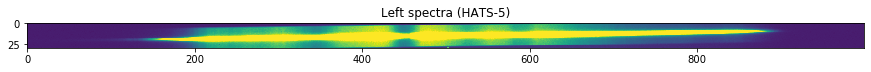

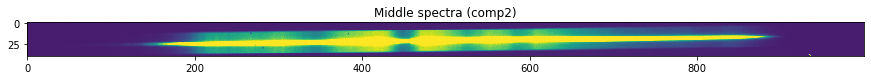

In [8]:
plt.figure(figsize=(15,2))
im = plt.imshow(data[1000:2000, 250:280].transpose())
im.set_clim(500,3500)
plt.title('Left spectra (HATS-5)')

plt.figure(figsize=(15,2))
im = plt.imshow(data[300:1300, 520:560].transpose())
im.set_clim(500,3500)
plt.title('Middle spectra (comp2)')

Let's check those positions stay more or less on the same spots for the last frame:

In [9]:
dlast = fits.open(datadir+'/ift0475c8.fits')
data_last, headers_last = dlast['PRIMARY'].data, dlast['PRIMARY'].header

Text(0.5, 1.0, 'Middle spectra (comp2, last frame)')

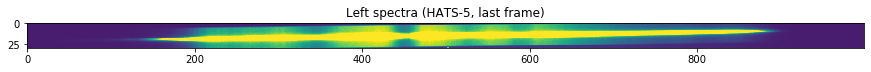

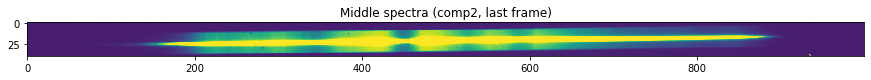

In [10]:
plt.figure(figsize=(15,2))
im = plt.imshow(data[1000:2000, 250:280].transpose())
im.set_clim(500,3500)
plt.title('Left spectra (HATS-5, last frame)')

plt.figure(figsize=(15,2))
im = plt.imshow(data[300:1300, 520:560].transpose())
im.set_clim(500,3500)
plt.title('Middle spectra (comp2, last frame)')

Yep, they _mostly_ do! We from hereon thus, play with these "cuts", which will make the whole analysis much easier. We define these cuts below:

In [11]:
idx_top = [250, 280]
idx_bottom = [520,560]

## 3. Quick (and very dirty) background substraction

All right, let's see if we can do a simple column-to-column substraction on these cuts to remove the sky + detector backgrounds. We play with the first frame data first. 

Let's see if a simple median accross all columns does the trick. Let's first write a function that does this:

In [12]:
def c2c_substraction(input_spectra):
    bkg_spectra = np.nanmedian(input_spectra, axis = 0)
    return input_spectra - bkg_spectra

In [13]:
top_spectra = data[1000:2000, idx_top[0]:idx_top[1]].transpose()
bottom_spectra = data[300:1300, idx_bottom[0]:idx_bottom[1]].transpose()

In [14]:
corrected_top_spectra = c2c_substraction(top_spectra)
corrected_bottom_spectra = c2c_substraction(bottom_spectra)

Text(0.5, 1.0, 'Bottom spectra (corrected)')

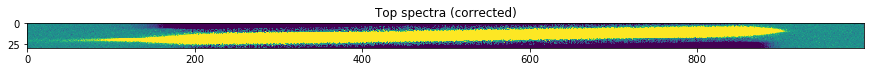

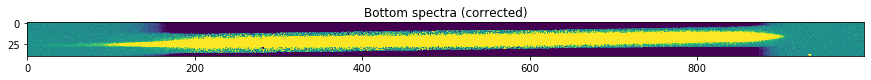

In [15]:
plt.figure(figsize=(15,2))
im = plt.imshow(corrected_top_spectra)
im.set_clim(-100,100)
plt.title('Top spectra (corrected)')

plt.figure(figsize=(15,2))
im = plt.imshow(corrected_bottom_spectra)
im.set_clim(-100,100)
plt.title('Bottom spectra (corrected)')

(-1000, 5000)

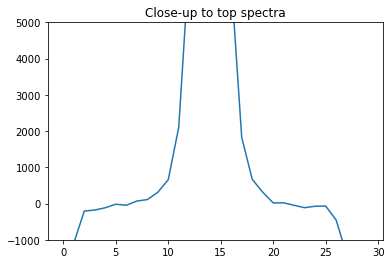

In [16]:
plt.title('Close-up to top spectra')
plt.plot(corrected_top_spectra[:,600])
plt.ylim(-1000,5000)

Hey, that's pretty good for such a simple procedure! As a quick-look to _all_ the data, let's do this same thing to all the data, add all fluxes between columns 1000 and 3500 (which is where we have the maximum of flux for both traces) which have _positive counts_ to get an estimate on the lightcurve of our stars. We extract the times as well to plot time versus flux:

In [17]:
start_times = np.array([])
flux_top, flux_bottom = np.array([]), np.array([])

for i in range(len(files)):
    # Extract frame number:
    nframe = int(files[i].split('ift')[-1].split('c8')[0]) 
    # If frame number is larger than 101 and smaller than 475, move along:
    if nframe > 100 and nframe < 476:
        # Extract data:
        d = fits.open(files[i])
        data, headers = d['PRIMARY'].data, d['PRIMARY'].header
    
        # Extract times:
        date = headers['UT-DATE']
        time = headers['UT-TIME']
        tt = [date +'T'+time]
        t = Time(tt, format='isot', scale='utc')
        start_times = np.append(start_times, t.jd[0])
    
        # Extract data, get corrected images:
        top_spectra = data[1000:2000, idx_top[0]:idx_top[1]].transpose()
        bottom_spectra = data[300:1300, idx_bottom[0]:idx_bottom[1]].transpose()
        top_spectra = c2c_substraction(top_spectra)
        bottom_spectra = c2c_substraction(bottom_spectra)
    
        # Extract fluxes by simple summation:
        idx1 = np.where(top_spectra>0)
        idx2 = np.where(bottom_spectra>0)
        flux_top = np.append(flux_top, np.sum(top_spectra[idx1]))
        flux_bottom = np.append(flux_bottom, np.sum(bottom_spectra[idx2]))

All right; let's plot the fluxes of the top and bottom spectra:

Text(0.5, 0, 'Time since start (hours)')

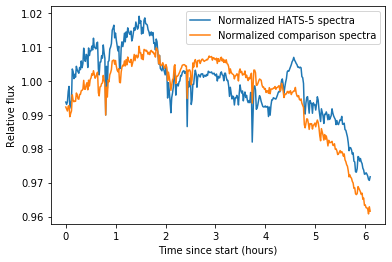

In [18]:
plt.plot((start_times - start_times[0])*24, flux_top/np.median(flux_top), label = 'Normalized HATS-5 spectra')
plt.plot((start_times - start_times[0])*24, flux_bottom/np.median(flux_bottom), label = 'Normalized comparison spectra')
plt.legend()
plt.ylabel('Relative flux')
plt.xlabel('Time since start (hours)')

Text(0.5, 0, 'Time since start (hours)')

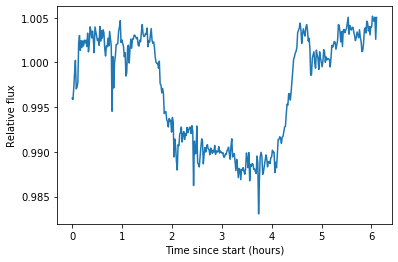

In [19]:
nlc = flux_top/flux_bottom
nlc = nlc/np.median(nlc)
plt.plot((start_times - start_times[0])*24, nlc, label = 'HATS-5 divided by comparison')
plt.ylabel('Relative flux')
plt.xlabel('Time since start (hours)')

In [22]:
headers

SIMPLE  =                    T                                                  
BITPIX  =                   16                                                  
NAXIS   =                    2                                                  
NAXIS1  =                 1088                                                  
NAXIS2  =                 2112                                                  
BSCALE  =           1.00000000         / real=bzero+bscale*value                
BZERO   =       32768.00000000                                                  
BUNIT   = 'DU/PIXEL'                                                            
ORIGIN  = 'LCO/OCIW'                                                            
OBSERVER= 'N.Morrell'                  / observer name                          
TELESCOP= 'Baade_Mag_1'                / telescope                              
SITENAME= 'LCO'                                                                 
SITEALT =                 24